In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

- The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.

# DATA PRE-PROCESSING

**Source** :

* The data was obtained from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Taiwanese+Bankruptcy+Prediction

In [26]:
# reading the file
df = pd.read_csv("../data/raw/data.csv")

- This data set contains a total of 95 independent variables or features and 1 target variable

In [27]:
df.shape

(6819, 96)

- we can see that there are no nulls in the data set so lets check for duplicates

In [28]:
# checking for nulls
count = [-1 for i in df.columns if df[i].isna().sum() == 0]
if -1 in count:
  print("there are no columns with nulls in the data set")

there are no columns with nulls in the data set


- There are no duplicate values in the data set

In [29]:
# Checking for duplicates in the data set
df.duplicated().sum()

np.int64(0)

In [30]:
df = df.rename(columns={'Bankrupt?':'Bankrupt'})

In [31]:
# gettng the names of the columns that have a single value in them and dropping them from the data set
col_1_value = [i for i in df.columns if len(df[i].value_counts().tolist()) == 1]

In [32]:
col_1_value

[' Net Income Flag']

# EDA

- From the below graph we can see that the data is completely imbalanced
- Which inturn leads to a biased prediction at the end
- To avoid this we will be using SMOTE technique to treat the data imbalanace.

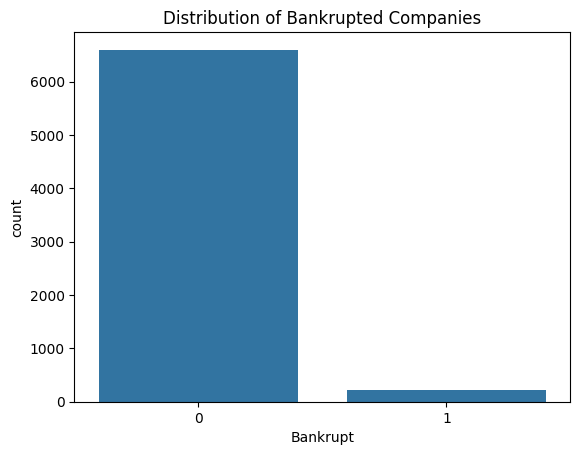

In [33]:
sns.countplot(data=df,x='Bankrupt')
plt.title("Distribution of Bankrupted Companies")
plt.show()

In [34]:
# checking the imablance in the dataset
df['Bankrupt'].value_counts()

Bankrupt
0    6599
1     220
Name: count, dtype: int64

 - The ratio of the number of samples in the majority class to the number of samples in the minority class is given as imbalance ratio which is very large as we can see the value below.



In [35]:
majority_samples = df['Bankrupt'].value_counts()[0]
minority_samples = df['Bankrupt'].value_counts()[1]
Imbalance_Ratio= majority_samples/minority_samples
print(f"Imbalance Ratio is:{round(Imbalance_Ratio)}")

Imbalance Ratio is:30


- There isn't much difference in operating gross margin between comapnies that are bankrupt and companies that did not bankrupt

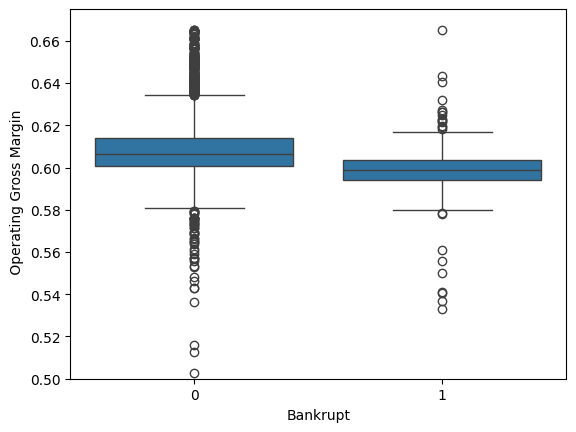

In [36]:
sns.boxplot(data = df, x='Bankrupt',y=' Operating Gross Margin')
plt.ylim(0.5,0.675)
plt.show()

- Apart from few features that are evenly spread out, most of them belongs in between a range of values.

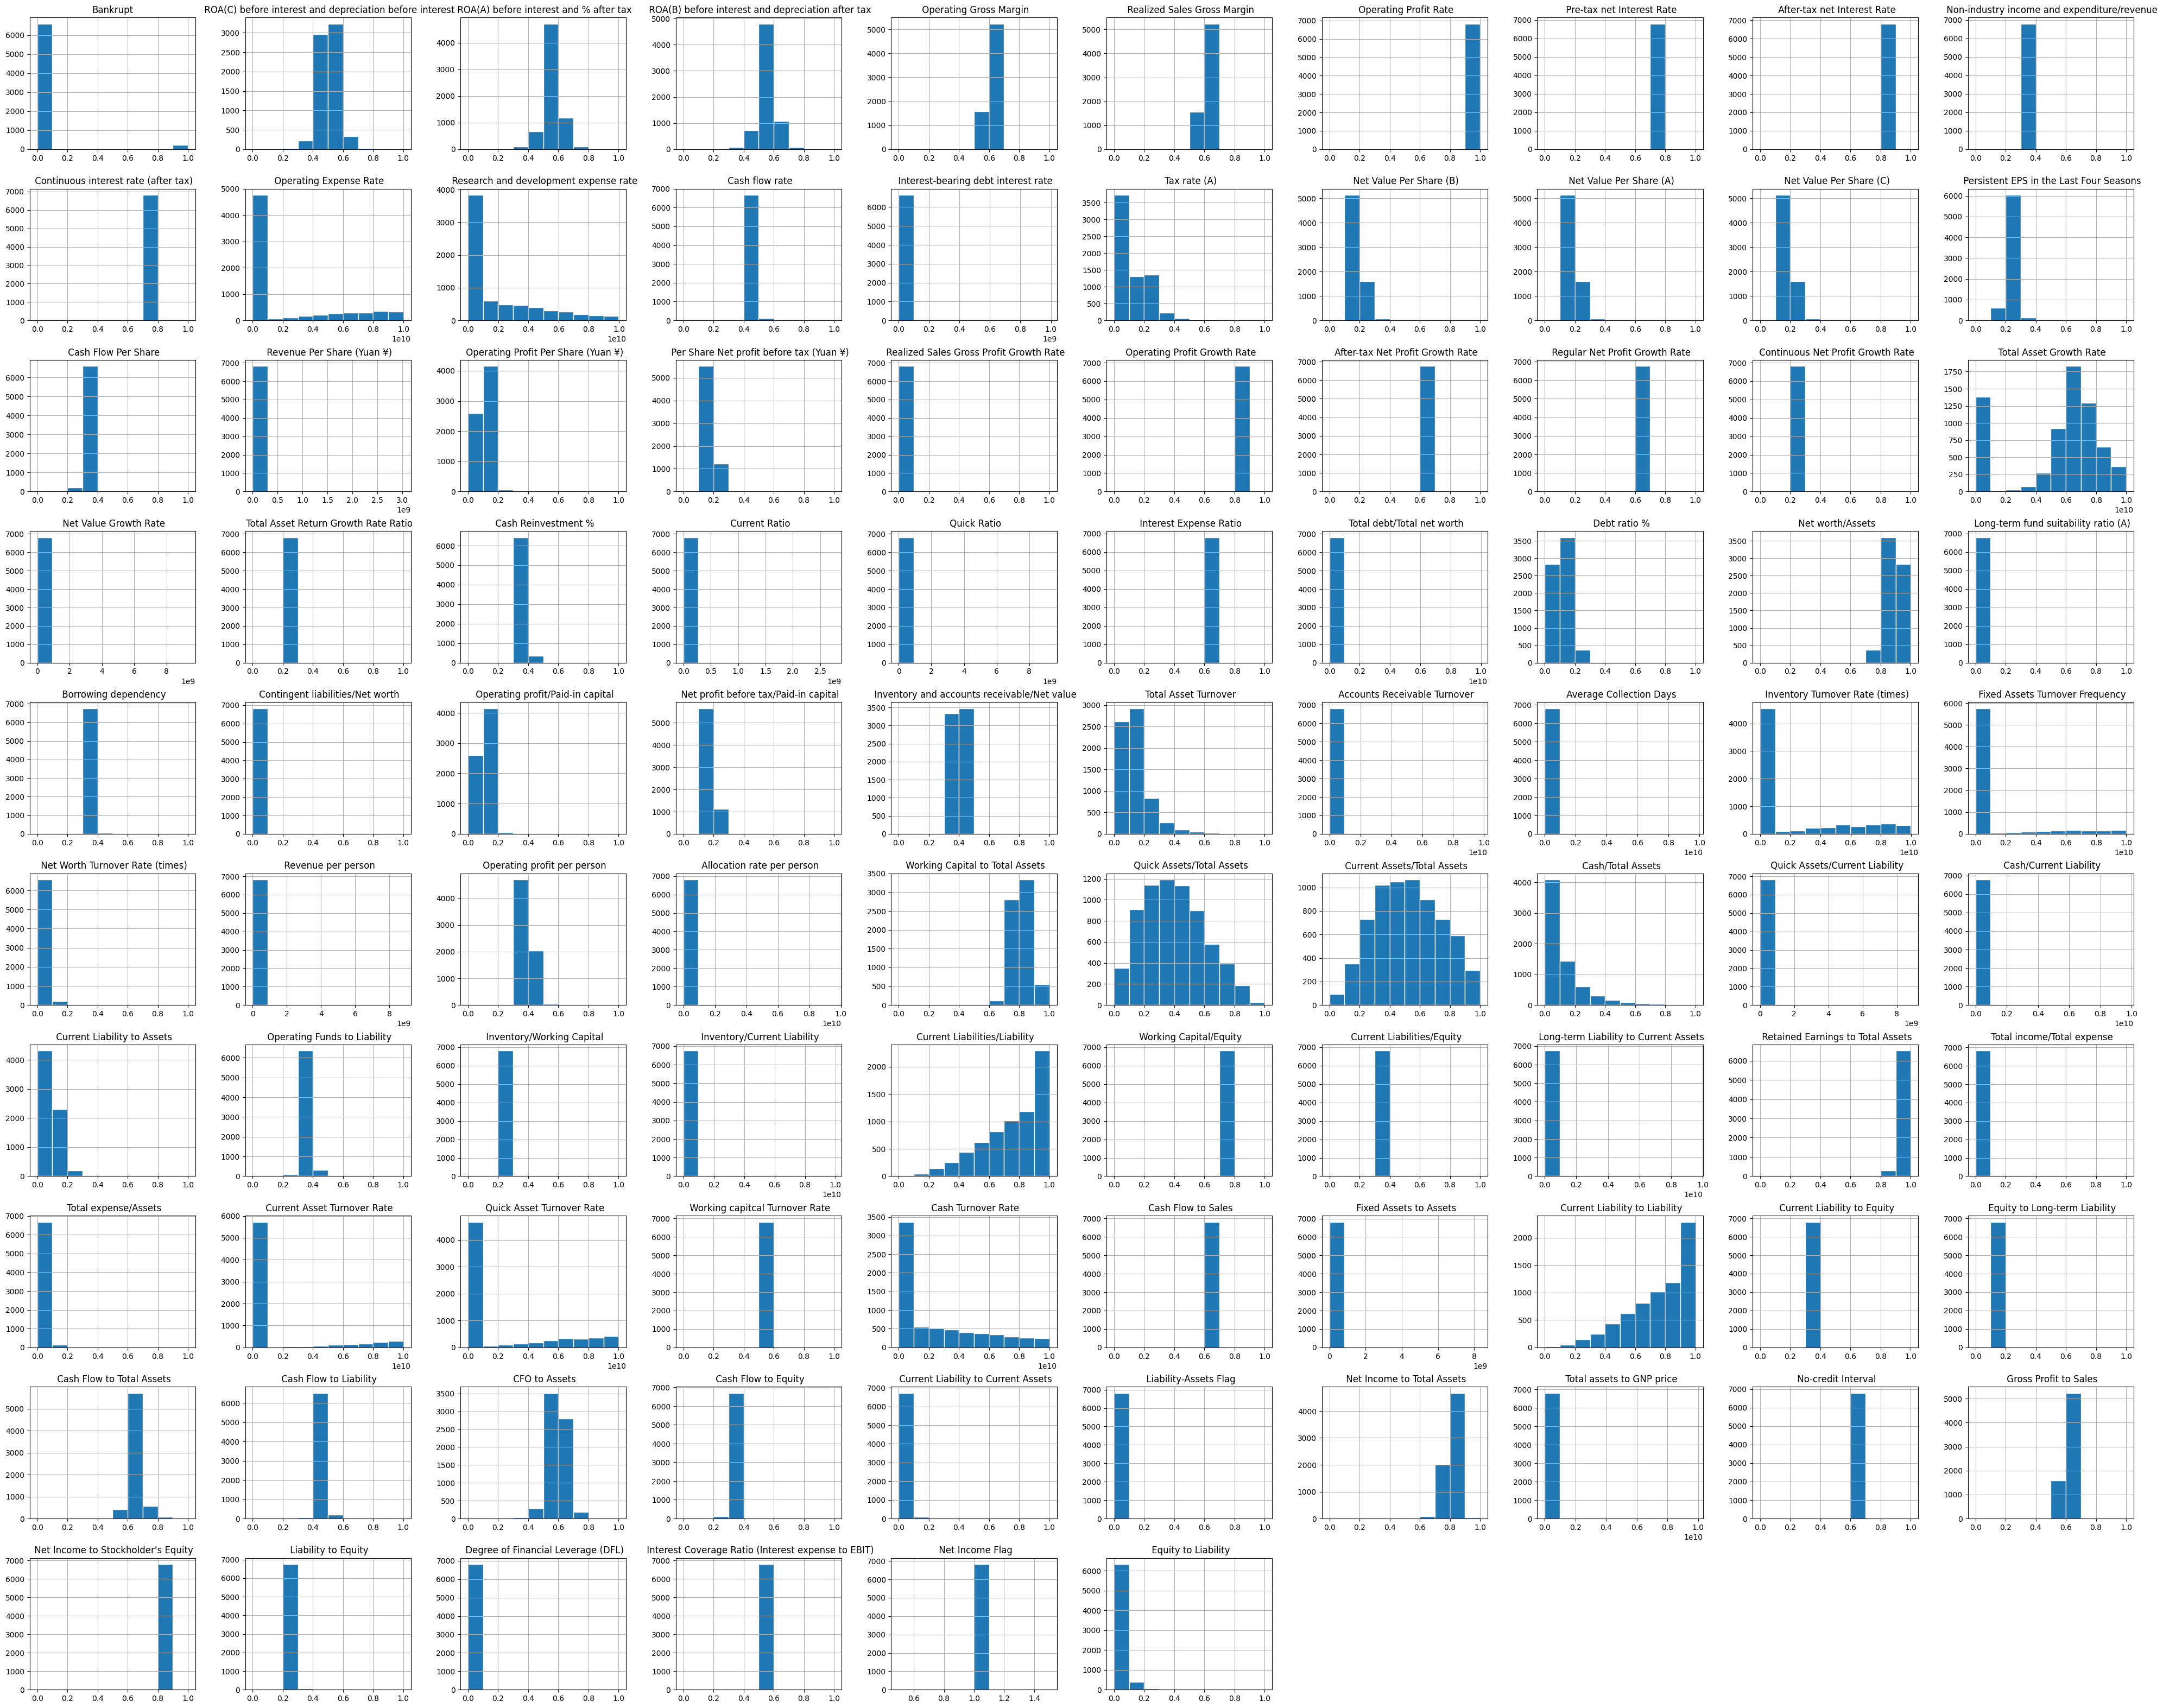

In [37]:
df.hist(figsize=(50,40), edgecolor='white')
plt.show()

- There are too many columns involved to do EDA if we proceed further we will be affected by curse of dimensionaliy for sure so selecting columns in a careful way.

- Checking for the highly correlated features

In [38]:
correlation_matrix = df.corr()

# Find columns with a correlation of 1 with any other column
columns_to_remove = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) == 1:
            # Add the column name to the set of columns to remove
            columns_to_remove.add(correlation_matrix.columns[i])

# Convert the set of columns to remove to a list
columns_to_remove = list(columns_to_remove)

# Drop the columns with a correlation of 1
df1 = df.drop(columns=columns_to_remove)
print(columns_to_remove)

[' Current Liability to Equity', ' Current Liability to Liability']


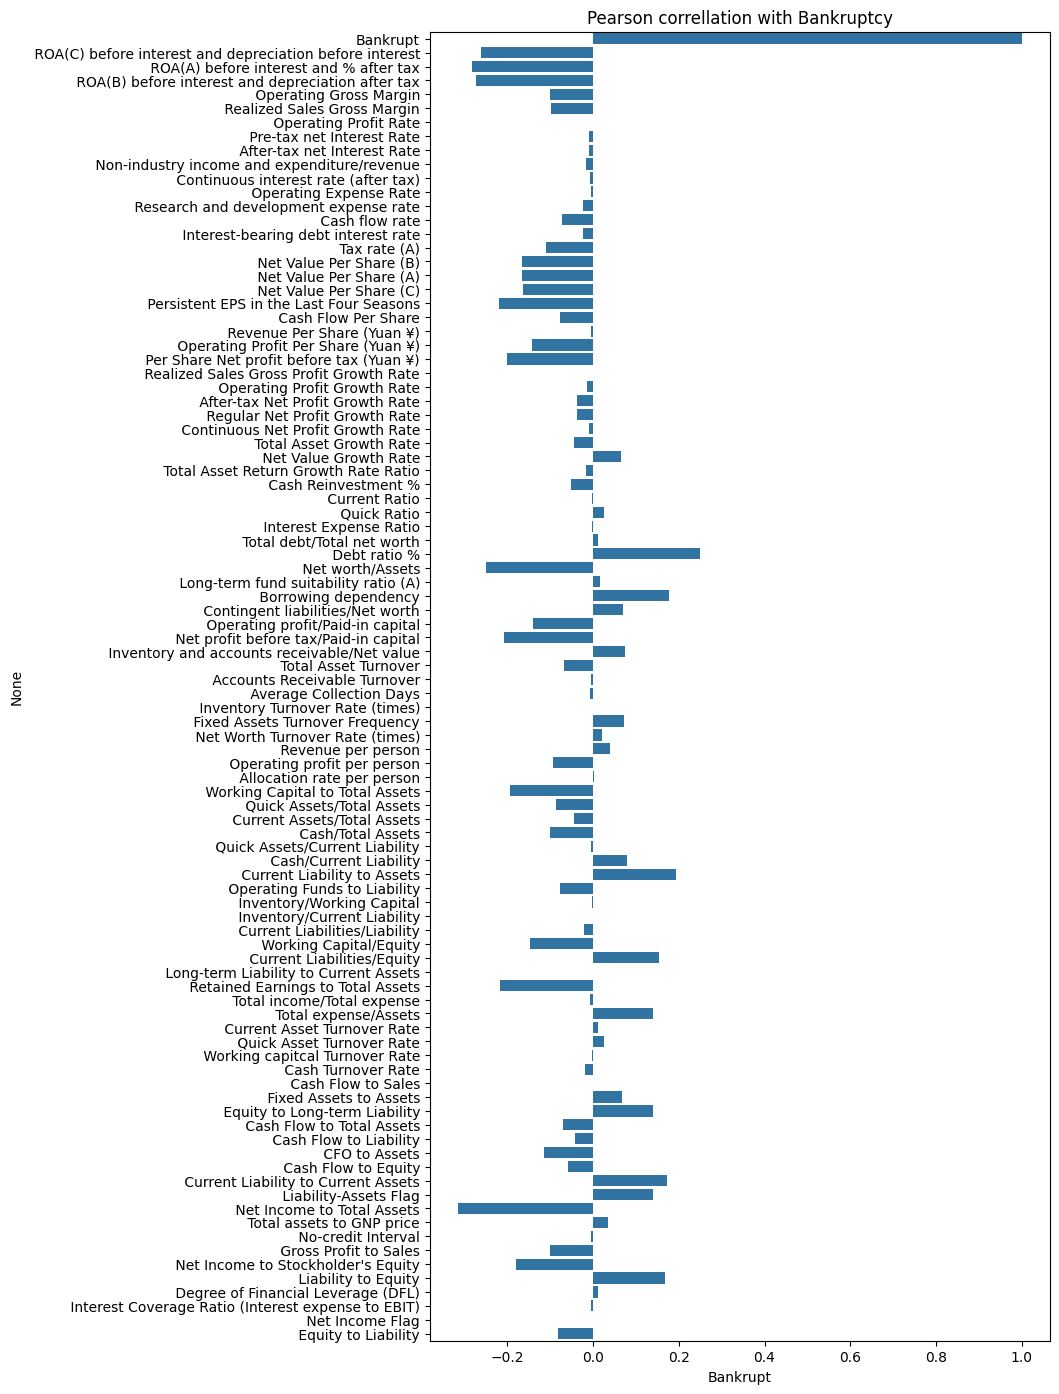

In [39]:
company_corr = pd.DataFrame(df1.corr(numeric_only=True))
company_corr = pd.DataFrame(company_corr['Bankrupt'])

plt.figure(figsize=(8, 17))
sns.barplot(y=company_corr.index,x=company_corr['Bankrupt'])
plt.title("Pearson correllation with Bankruptcy")
plt.show()

- Lets remove columns with correlation with other columns = 1.0, which means both the columns has same information

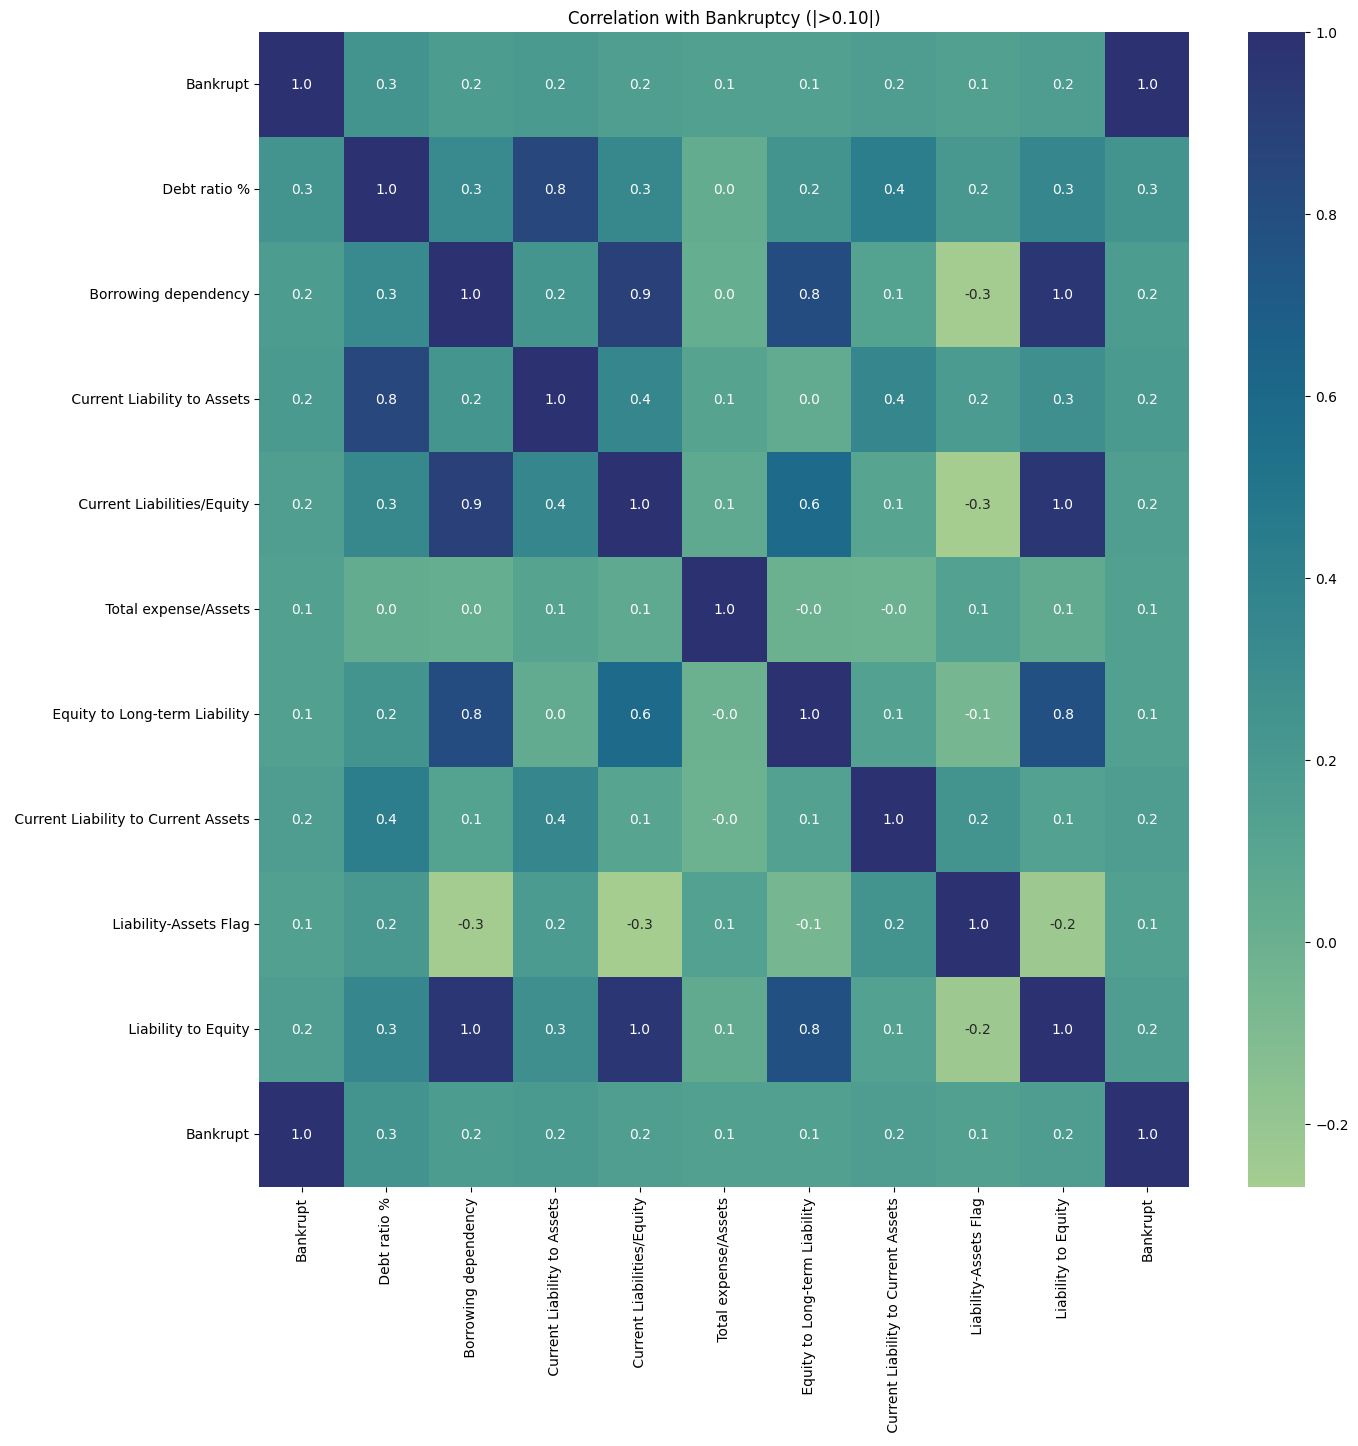

In [40]:
temp_corr = company_corr
correlated_features = list(temp_corr[(temp_corr["Bankrupt"] > 0.10)].index)+["Bankrupt"]
corr_test = df1[correlated_features]

plt.figure(figsize=(15, 15))
corr = corr_test.corr()

sns.heatmap(corr,cmap="crest",annot=True, fmt=".1f")
plt.title("Correlation with Bankruptcy (|>0.10|)")
plt.show()

In [41]:
independent_variable = df.drop(['Bankrupt'], axis=1)
target_variable = df[['Bankrupt']]
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(independent_variable,pd.Series.ravel(target_variable))
importances = pd.Series(importances,independent_variable.columns[0:len(independent_variable.columns)])
importances = pd.DataFrame({'features':importances.index, 'importance':importances.values})
selected_columns_set_linear = [
 ' ROA(A) before interest and % after tax',
 ' Net Value Per Share (A)',
 ' Debt ratio %',
 ' Working Capital to Total Assets',
 ' Current Liability to Current Assets',
 " Net Income to Stockholder's Equity",
 ' Operating Gross Margin',
 'Bankrupt']
# Lets select top 10 columns for EDA and Modelling
selected_columns_set_non_linear = np.array(importances.nlargest(5,'importance').features)
selected_columns = [*selected_columns_set_linear , *selected_columns_set_non_linear]
selected_columns = np.unique(selected_columns)

C:\Users\nikhi\AppData\Local\Temp\ipykernel_32628\761866671.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  importances = mutual_info_classif(independent_variable,pd.Series.ravel(target_variable))


In [42]:
selected_columns

array([' Borrowing dependency', ' Current Liability to Current Assets',
       ' Debt ratio %', " Net Income to Stockholder's Equity",
       ' Net Value Per Share (A)',
       ' Net profit before tax/Paid-in capital',
       ' Operating Gross Margin',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Persistent EPS in the Last Four Seasons',
       ' ROA(A) before interest and % after tax',
       ' Working Capital to Total Assets', 'Bankrupt'], dtype='<U41')

In [43]:
df2=pd.DataFrame()
for i in selected_columns:
  df2[i]=df[i]

In [44]:
df2.head()

,Borrowing dependency,Current Liability to Current Assets,Debt ratio %,Net Income to Stockholder's Equity,Net Value Per Share (A),Net profit before tax/Paid-in capital,Operating Gross Margin,Per Share Net profit before tax (Yuan ¥),Persistent EPS in the Last Four Seasons,ROA(A) before interest and % after tax,Working Capital to Total Assets,Bankrupt
0,0.390284,0.118250,0.207576,0.827890,0.147950,0.137757,0.601457,0.138736,0.169141,0.424389,0.672775,1
1,0.376760,0.047775,0.171176,0.839969,0.182251,0.168962,0.610235,0.169918,0.208944,0.538214,0.751111,1
2,0.379093,0.025346,0.207516,0.836774,0.177911,0.148036,0.601450,0.142803,0.180581,0.499019,0.829502,1
3,0.379743,0.067250,0.151465,0.834697,0.154187,0.147561,0.583541,0.148603,0.193722,0.451265,0.725754,1
4,0.375025,0.047725,0.106509,0.839973,0.167502,0.167461,0.598783,0.168412,0.212537,0.538432,0.751822,1


Before Jumping into EDA, lets understand what each column means :

- Borrowing dependency: Borrowing dependency refers to a company's reliance on borrowed funds, such as loans or credit, to finance its operations or investments. It indicates the extent to which a company utilizes external debt to support its activities rather than relying solely on internal resources.

- Current Liability to Current Assets: This ratio compares a company's current liabilities (obligations due within one year) to its current assets (assets expected to be converted into cash within one year). It provides an indication of a company's ability to meet its short-term obligations using its short-term assets. A higher ratio may suggest a greater risk of liquidity issues.

- Debt ratio %: The debt ratio is a financial metric that compares a company's total debt to its total assets. It represents the proportion of a company's assets that are financed by debt. A higher debt ratio indicates a higher level of debt relative to assets, which may imply higher financial risk and reduced financial flexibility.

- Net Income to Stockholder's Equity: This ratio, also known as return on equity (ROE), measures a company's profitability relative to its shareholders' equity. It indicates how effectively a company generates profit using the shareholders' investment. A higher ratio implies better profitability and efficient use of equity capital.

- Net Value Per Share (A): Net Value Per Share is a measure of a company's net assets (assets minus liabilities) divided by the total number of outstanding shares. It represents the per-share value of a company's net worth or book value.

- Net profit before tax/Paid-in capital: This ratio compares a company's net profit before tax to its paid-in capital. It indicates the profitability generated by each unit of capital invested by shareholders.

- Operating Gross Margin: Operating gross margin, also known as gross profit margin, measures the profitability of a company's core operations. It is calculated by dividing the gross profit (revenue minus the cost of goods sold) by the revenue. It represents the percentage of revenue that remains after deducting the direct costs associated with producing or delivering goods or services.

- Per Share Net profit before tax (Yuan ¥): Per Share Net profit before tax is the net profit before tax of a company divided by the total number of outstanding shares. It represents the earnings per share before tax.

- Persistent EPS in the Last Four Seasons: Persistent EPS (Earnings Per Share) in the Last Four Seasons refers to the average earnings per share of a company over the past four fiscal quarters. It provides an indication of the company's sustained profitability over a specific period.

- ROA(A) before interest and % after tax: Return on Assets (ROA) measures a company's ability to generate profit from its total assets. ROA(A) before interest and % after tax specifically refers to the return on assets before interest expenses and taxes. It indicates the profitability generated by each dollar of assets, excluding the impact of interest payments and taxes.

- Working Capital to Total Assets: This ratio compares a company's working capital (current assets minus current liabilities) to its total assets. It evaluates the proportion of a company's total assets that are funded by its working capital. A higher ratio suggests a higher reliance on short-term assets to finance a company's operations.

In [45]:
df2.describe()

,Borrowing dependency,Current Liability to Current Assets,Debt ratio %,Net Income to Stockholder's Equity,Net Value Per Share (A),Net profit before tax/Paid-in capital,Operating Gross Margin,Per Share Net profit before tax (Yuan ¥),Persistent EPS in the Last Four Seasons,ROA(A) before interest and % after tax,Working Capital to Total Assets,Bankrupt
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.374654,0.031506,0.113177,0.840402,0.190633,0.182715,0.607948,0.184361,0.228813,0.558625,0.814125,0.032263
std,0.016286,0.030845,0.053920,0.014523,0.033474,0.030785,0.016934,0.033180,0.033263,0.065620,0.059054,0.176710
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.370168,0.018034,0.072891,0.840115,0.173613,0.169376,0.600445,0.170370,0.214711,0.535543,0.774309,0.000000
50%,0.372624,0.027597,0.111407,0.841179,0.184400,0.178456,0.605997,0.179709,0.224544,0.559802,0.810275,0.000000
75%,0.376271,0.038375,0.148804,0.842357,0.199570,0.191607,0.613914,0.193493,0.238820,0.589157,0.850383,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Scatter plot - Relationship between features with Bankruptcy hue
sns.pairplot(df2, hue='Bankrupt',plot_kws={'alpha': 0.5})
plt.show()

# Modelling

In [47]:
# Lets split features and target variable into X and y
X = df2.drop(['Bankrupt'],axis=1)
y = df2['Bankrupt']

- Using sampling to treat the data imbalance

In [48]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

- as you can see in the below plot the imbalance ratio is quite less when compared with other

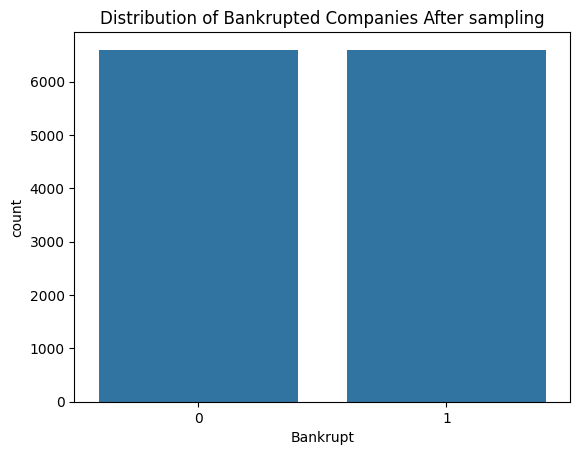

In [49]:
sns.countplot(x=y_resampled)
plt.title("Distribution of Bankrupted Companies After sampling")
plt.show()

- Creating base line models

In [50]:
# Get model performance
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score,log_loss,roc_curve,classification_report, confusion_matrix,roc_curve, auc
def get_model_performance(model_name,model,X_test,y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    precision = round(precision_score(y_test,y_pred,average = "macro"),2)
    recall = round(recall_score(y_test,y_pred,average = "macro"),2)
    auc = round(roc_auc_score(y_test,y_prob[:,1]),2)
    l_loss = round(log_loss(y_test,y_prob),3)
    f1 = round(f1_score(y_test,y_pred,average = "macro"),2)
    accuracy = round(accuracy_score(y_test,y_pred),2)

    performance_metrics = {
        "model":model_name,
        "precision_macro":precision,
        "recall_macro":recall,
        "auc":auc,
        "log_loss":l_loss,
        "f1_macro":f1,
        "accuracy":accuracy,
    }
    return performance_metrics
def print_confusion_matrix(y_true,y_pred):

    cf_matrix = confusion_matrix(y_true,y_pred)

    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def print_model_performance(model_name,model,X_test,y_test):
    print(f'{model_name} : ')
    y_pred = model.predict(X_test)

    print(f'{model_name} : Classification Report ')
    print(classification_report(y_test,y_pred))

    print(f'{model_name} : Confusion Matrix ')
    print_confusion_matrix(y_test,y_pred)

    print(f'{model_name} : Auc Roc Curve ')
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc), linestyle='--')
    plt.plot([0, 1], [0, 1], color='navy', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()



In [51]:
# Creating base models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

log_reg_model = LogisticRegression(random_state=42)
svm_model = SVC(random_state=42,probability=True)
decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()

In [52]:
# Split resampled data set to train and test samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_resampled, y_resampled, test_size=0.30, random_state=42)

In [31]:
# Training baseline models
log_reg_model.fit(X_train,y_train)
svm_model.fit(X_train,y_train)
decision_tree_model.fit(X_train,y_train)
random_forest_model.fit(X_train,y_train)
knn_model.fit(X_train,y_train)

log_reg_base_perf = get_model_performance("Logistic Regression",log_reg_model,X_test,y_test)
svm_base_perf = get_model_performance("SVM",svm_model,X_test,y_test)
decision_tree_base_perf = get_model_performance("Decision tree",decision_tree_model,X_test,y_test)
random_forest_base_perf = get_model_performance("Random forest",random_forest_model,X_test,y_test)
knn_base_perf = get_model_performance("KNN",knn_model,X_test,y_test)

In [ ]:
# Performance of baseline models
print_model_performance("1. Logistic regression",log_reg_model,X_test,y_test)
print_model_performance("2. SVM",svm_model,X_test,y_test)
print_model_performance("3. Decision Tree",decision_tree_model,X_test,y_test)
print_model_performance("4. Random Forest",random_forest_model,X_test,y_test)
print_model_performance("6. K-Nearest Neighbours",knn_model,X_test,y_test)

# Summary of Baseline Models

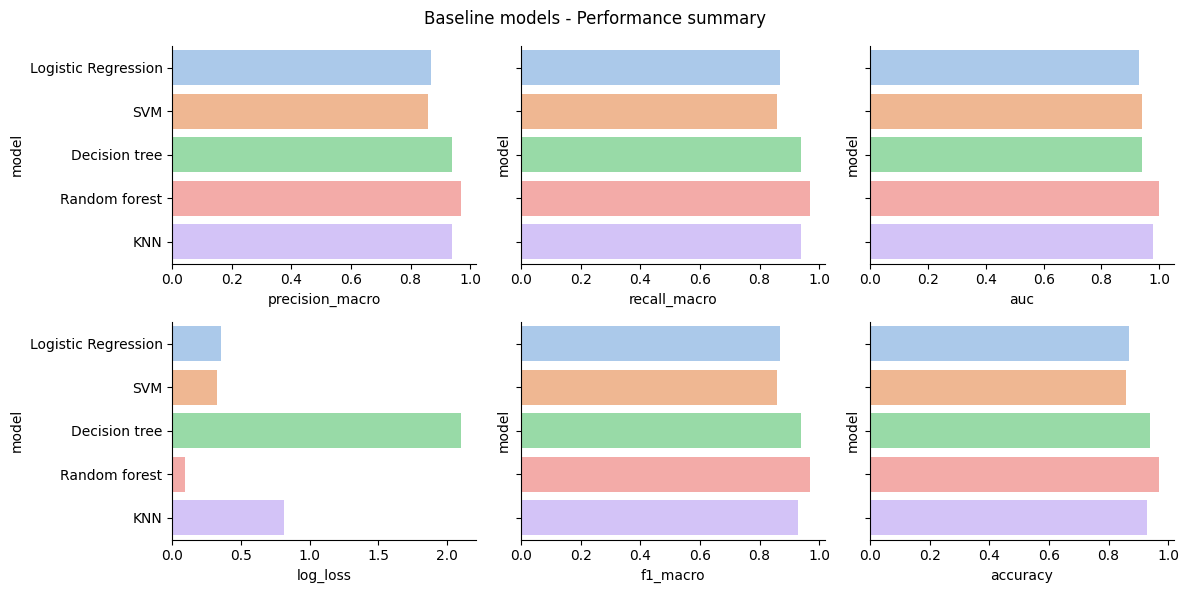

In [35]:
baseline_model_perf = pd.DataFrame([log_reg_base_perf,svm_base_perf,decision_tree_base_perf,random_forest_base_perf,knn_base_perf])
sns.set_palette("pastel")

fig, axs = plt.subplots(nrows = 2,ncols=3, sharey=True, figsize=(12, 6))

plot1 = sns.barplot(data = baseline_model_perf,x = 'precision_macro', y = 'model',ax=axs[0][0])
plot2 = sns.barplot(data = baseline_model_perf,x = 'recall_macro', y = 'model',ax=axs[0][1])
plot3 = sns.barplot(data = baseline_model_perf,x = 'auc', y = 'model',ax=axs[0][2])
plot4 = sns.barplot(data = baseline_model_perf,x = 'log_loss', y = 'model',ax=axs[1][0])
plot5 = sns.barplot(data = baseline_model_perf,x = 'f1_macro', y = 'model',ax=axs[1][1])
plot6 = sns.barplot(data = baseline_model_perf,x = 'accuracy', y = 'model',ax=axs[1][2])

sns.despine()
plt.suptitle("Baseline models - Performance summary")
plt.subplots_adjust(wspace = 0.3,hspace=0.3,top=0.9)
plt.tight_layout()
plt.show()


# Random Forest With HPT

- I think random forest is the best model in all the models here but it is certainly overfitting lets do hpt and then fit the data

In [54]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
random_forest_params = {
    'n_estimators': [25, 50, 75, 100],
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'min_samples_split': [2, 5, 10],
    'criterion': ["gini", "entropy"],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=random_forest_params,
                           scoring='accuracy', cv=5, n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)  # Replace X_train and y_train with your training data

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator (trained model with best hyperparameters)
best_rf_model = grid_search.best_estimator_

Best Hyperparameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 75}


Random Forest : 
Random Forest : Classification Report 
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2005
           1       0.95      0.98      0.97      1955

    accuracy                           0.97      3960
   macro avg       0.97      0.97      0.97      3960
weighted avg       0.97      0.97      0.97      3960

Random Forest : Confusion Matrix 


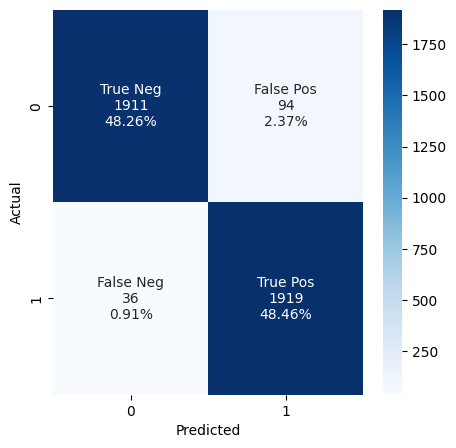

Random Forest : Auc Roc Curve 


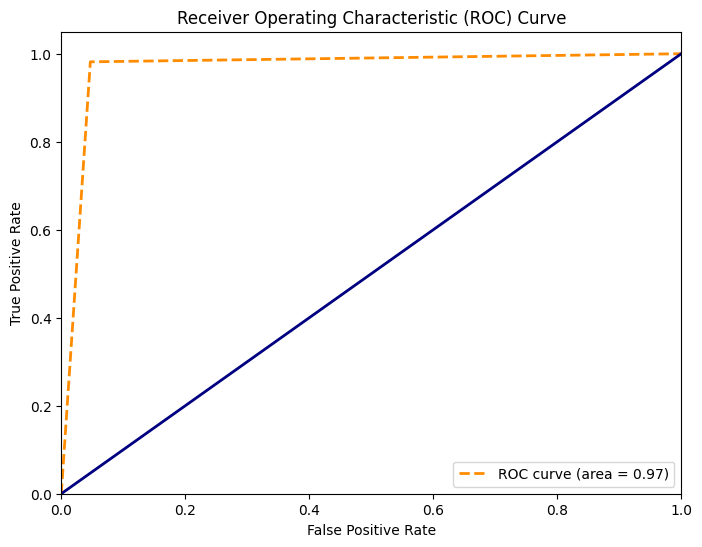

In [55]:
random_forest_perf = get_model_performance("Random forest",best_rf_model,X_test,y_test)
print_model_performance("Random Forest",best_rf_model,X_test,y_test)

In [58]:
import joblib

# Save the best random forest model to a file
joblib.dump(best_rf_model, '../artifacts/best_model.pkl')

['../artifacts/best_model.pkl']

# Summary

- Random forest model is selected as our final model and it represents the data in best possible way and satisfactory performence compared to other models